# Notebook for developing diffrax/JAX based reconstruction package for XNH

First, imports:

In [32]:
from diffrax import *
import diffrax as dx
from diffrax.functional import *
from diffrax import LightField, TransFormPropagate
from diffrax.utils.types import LazyGrid, Spectrum
from diffrax.utils import OpticalElement, OpticalLayer

import jax.numpy as jnp
from jax import random
from jax import grad, jit, vmap
import jax

from einops import rearrange, repeat, reduce
from flax.traverse_util import flatten_dict
from flax.core import unfreeze
import flax.linen as nn

from typing import Tuple, Callable, Sequence, Union
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

Second, handy functions:

In [25]:
def show_fields(fields, empty_field=None, orientation='landscape'):
    eb = empty_field is not None
    intensity = fields.intensity.squeeze()
    phase = fields.phase.squeeze()

    if orientation.lower() == 'portrait':
        _, axs = plt.subplots(fields.u.shape[0] + eb, 2, figsize=(10, 5*(fields.u.shape[0] + eb)))
        if eb:
            axs[0,0].imshow(empty_field.intensity.squeeze())
            axs[0,1].imshow(empty_field.phase.squeeze())

        if len(axs.shape) == 2:
            for i, ax in enumerate(axs[eb:, :]):
                ax[0].imshow(intensity[i,...])
                ax[1].imshow(phase[i,...])
            
            axs[0,0].set_title('Intensity')
            axs[0,1].set_title('Phase')

        else:            
            axs[0].imshow(intensity)
            axs[1].imshow(phase)            
            axs[0].set_title('Intensity')
            axs[1].set_title('Phase')
    else:
        _, axs = plt.subplots(2, fields.u.shape[0] + eb, figsize=(5*(fields.u.shape[0] + eb), 10))
        if eb:
            axs[0,0].imshow(empty_field.intensity.squeeze())
            axs[1,0].imshow(empty_field.phase.squeeze())

        if len(axs.shape) == 2:
            for i, ax in enumerate(axs[:, eb:].T):
                ax[0].imshow(intensity[i,...])
                ax[1].imshow(phase[i,...])
            
            axs[0,0].set_title('Intensity')
            axs[1,0].set_title('Phase')
        else:            
            axs[0].imshow(intensity)
            axs[1].imshow(phase)            
            axs[0].set_title('Intensity')
            axs[1].set_title('Phase')

def show_images(images, empty_image=None, orientation='landscape'):
    eb = empty_image is not None
    intensity = images.squeeze()

    if orientation.lower() == 'portrait':
        _, axs = plt.subplots(intensity.shape[0] + eb, 1, figsize=(5, 5*(intensity.shape[0] + eb)))
    else:
        _, axs = plt.subplots(1, intensity.shape[0] + eb, figsize=(5*(intensity.shape[0] + eb), 5))

    if eb:
        axs[0].imshow(empty_image.squeeze())
    for i, ax in enumerate(axs[eb:]):
        ax.imshow(intensity[i,...])
    axs[0].set_title('Intensity')

Now, let's define some aspects of our system (based on CBxs_lobV_top_30nm at ESRF beamline i16a):

In [3]:
du = 0.03 # effective pixel size of detector (microns) (note: documented as pixelsize_detector = 3e-6 in ESRF script?)
z_total = 1.208 * 1000 # distance from focus point to detector (microns)
zs_f2s = jnp.array([0.012080, 0.012598, 0.014671, 0.018975]) * 1000 # distances source to sample (microns) 
dz = 1. # depth of slice in microns
zs_s2d = z_total - zs_f2s - dz # distances sample to detector (microns) 
lambda_ =  7.25146e-5 # wavelength in microns for 17kEV (~3.62573e-05 um for 33kEV)
lambda_ratios = 1.0 # ratio of wavelengths
n = 0.999999999 # refractive index of x-rays is slightly below unity according to ESRF

Then get and display Siemens star test object (then make it into a phase object) and use it as ground truth (gt):

(1, 1024, 1024, 1)


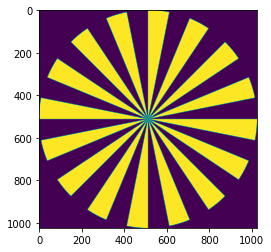

In [4]:
data = plt.imread('./Siemens_star.svg.png')
# data = repeat(jnp.abs(jnp.mean(data, axis=-1)), 'h w -> b h w 1', b = zs_f2s.size) 
data = jnp.expand_dims(jnp.expand_dims(jnp.abs(jnp.mean(data, axis=-1)), 0), -1) # 'h w -> b h w 1'
print(data.shape)
plt.imshow(data[0,...,0].squeeze())

In [5]:
# delta and beta should be 4d Tensors
delta = data * 1.2600 # phase change
beta = data * (1 - 0.98200) # 1 minus the extinction coefficient

Now let's make the lightfields hitting the sample and display their intensity and phase:

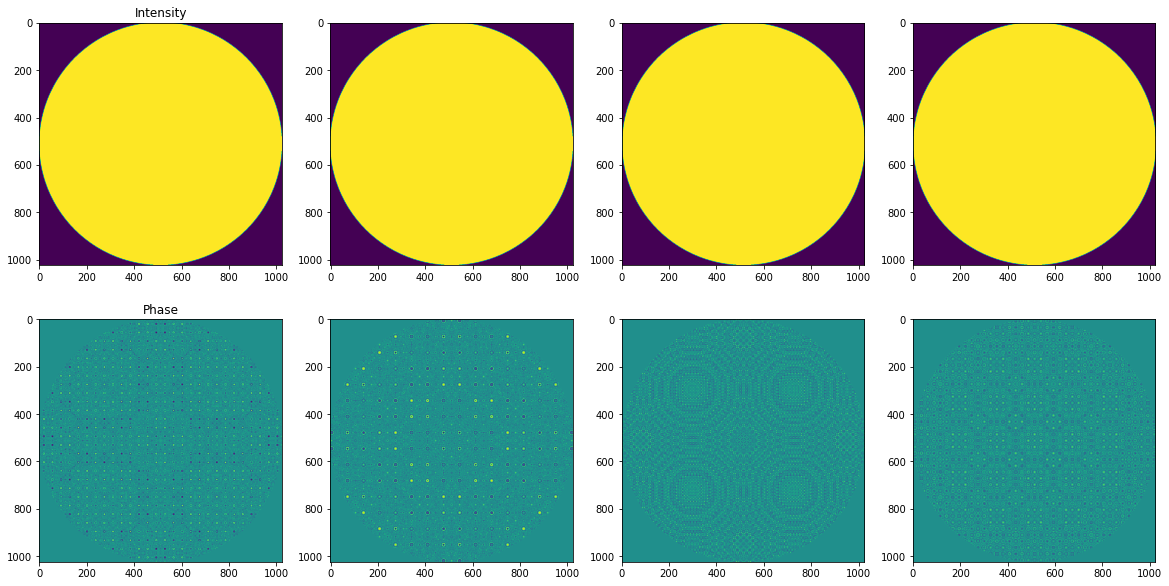

In [26]:
n_pixels = data.shape[1]
D = n_pixels * du

in_fields = pointsource((n_pixels, du), zs_f2s, D, n, lambda_, lambda_ratios)
show_fields(in_fields)

Now let's make some projections:

In [7]:
def phasechange(field: LightField, delta: jnp.ndarray, beta: jnp.ndarray, dz: float) -> LightField:
    k = 2 * jnp.pi / field.spectrum.wavelength
    u = field.u * jnp.exp(-1j * k * dz * (delta - 1j * beta))
    return field.replace(u=u)

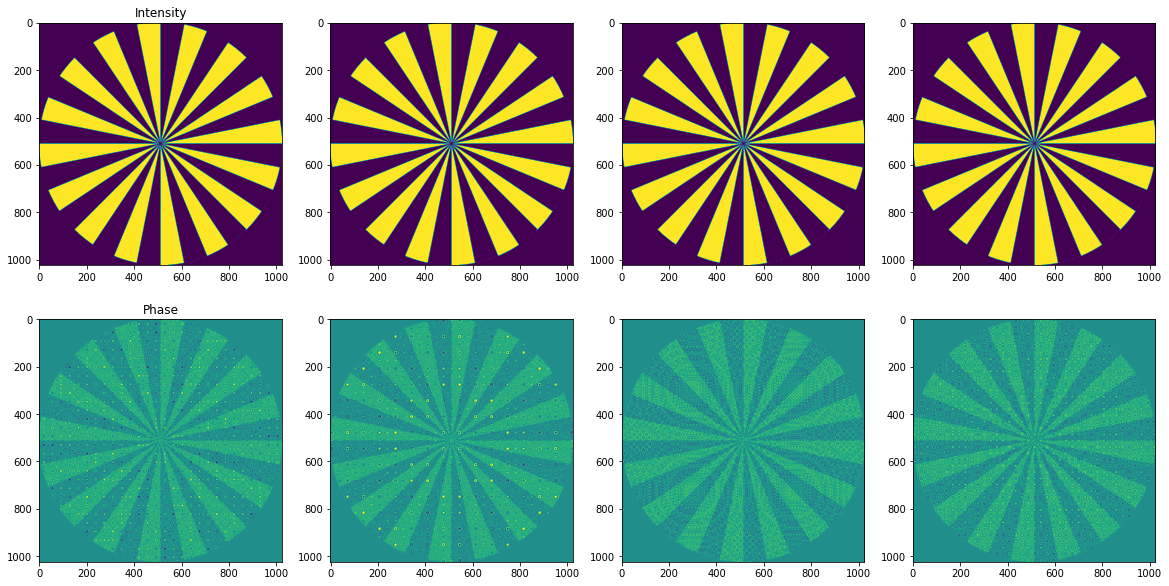

In [8]:
# out_fields = [phasechange(in_field, delta, beta, dz=dz) for in_field in in_fields]
out_fields = phasechange(in_fields, delta, beta, dz=dz)
show_fields(out_fields)

Let's add free space propagation after the sample:

In [9]:
def propagate(field, dz, n, D): # here dz is distance to propogate wave
    Nf = jnp.max((D / 2) ** 2 / (field.spectrum.wavelength * dz))
    M = field.u.shape[1]
    Q = M / (4 * Nf)
    N = int(jnp.ceil((Q * M) / 2) * 2)
    N_pad = max(0, int((N - M)))
    return transform_propagate(field, z=dz, n=n, N_pad=N_pad)

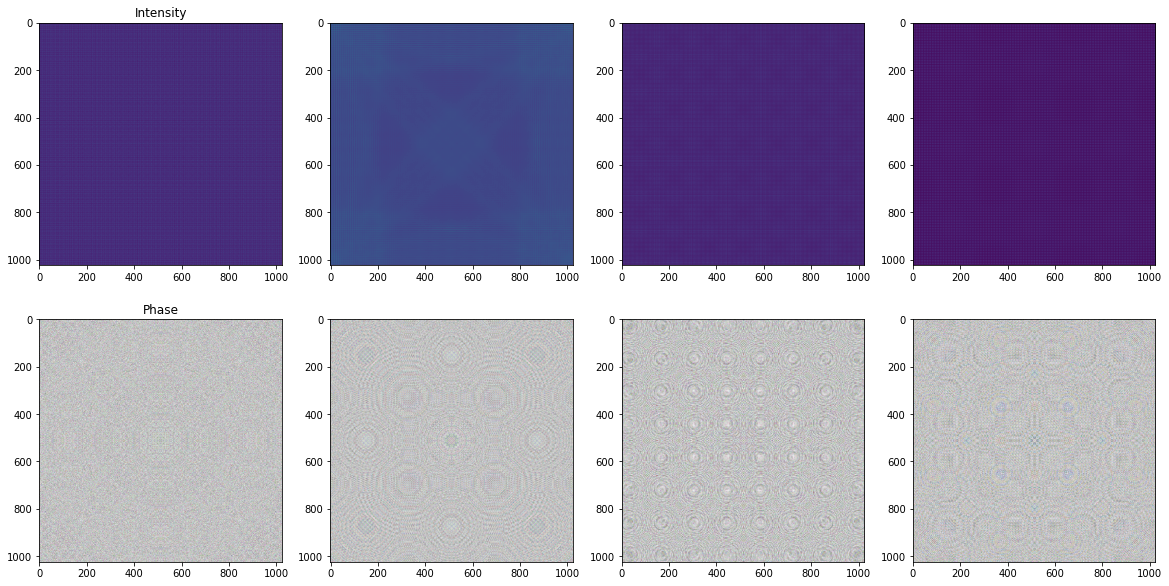

In [10]:
sensor_fields = propagate(in_fields, zs_s2d, n, D)
show_fields(sensor_fields)

Finally, let's collect everything as ground truths for different projection distances and the empty beam image:

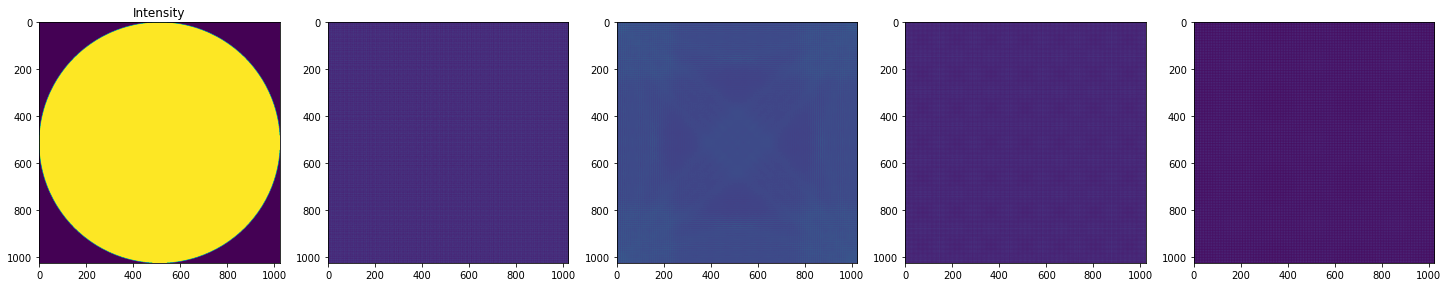

In [11]:
gt_sample_images = sensor_fields.intensity # these would be the sensor readings for each distance
gt_empty_beam = pointsource((n_pixels, du), z_total, D, n, lambda_, lambda_ratios).intensity

show_images(gt_sample_images, gt_empty_beam)

### Now let's see if we can reconstruct the sample from the sensor images

First, let's make some necessary variables, including making objects for parts of our imaging system.
Let's first remember the elements of our system, using the thin slice approximation for modeling the sample volume:
1) ```input_field```: Coherent monochromatic X-ray beam of wavelength ```lambda_``` and refractive index ```n``` in the system, focused by Kirkpatrick-Baez mirrors distances ```[zs_f2s]``` from the sample, and distance ```z_total``` from the detector/sensor.
2) ```phase_object```: The sample volume to estimate, modeled as a thin phase object with ```delta``` refractive index and ```beta``` extinction coefficient, ```[zs_f2s]``` from the beam focal point, and ```[zs_s2d]``` from the detector, with depth ```dz```.
3) ```propagation```: Propgation of the beam exiting the ```phase_object``` some ```[zs_s2d]``` distances to the detector/sensor, which should have some shot noise/manufacturing defects that produces the final images. TODO: Add noise OR **make sensor object incorporating noise/response model**

In [31]:
import diffrax as dx
from diffrax.functional import *
from diffrax import LightField, TransFormPropagate
from diffrax.utils.types import LazyGrid, Spectrum
from diffrax.utils import OpticalElement, OpticalLayer

import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import jax

from einops import rearrange, repeat, reduce
from flax.traverse_util import flatten_dict
from flax.core import unfreeze
import flax.linen as nn

from functools import partial
from typing import Tuple, Callable, Sequence, Union
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [14]:
class SingleProjection(nn.Module):    
    du: float = 0.03 # effective pixel size of detector (microns) (note: documented as pixelsize_detector = 3e-6 in ESRF script?)
    z_total: float = 1.208 * 1000 # distance from focus point to detector (microns)
    zs_f2s: jnp.array = jnp.array([0.012080, 0.012598, 0.014671, 0.018975]) * 1000 # distances source to sample (microns) 
    dz: float = 1. # depth of slice in microns
    # zs_s2d = z_total - zs_f2s - dz # distances sample to detector (microns) 
    lambda_: jnp.array =  7.25146e-5 # wavelength in microns for 17kEV (~3.62573e-05 um for 33kEV)
    lambda_ratios: jnp.array = 1.0 # ratio of wavelengths
    n: float = 0.999999999 # refractive index of x-rays is slightly below unity according to ESRF
    field_shape: int = 1024 #TODO: Determine if there should also be n_pixels

    @property
    def max_Npad(self):
        Nf = jnp.max((self.du / 2) ** 2 / (self.lambda_ * self.z_total))
        Q = 1 / (8 * Nf)
        N = int(jnp.ceil(Q) * 2)
        return max(0, int((N - self.field_shape)))
    
    @classmethod
    def phasechange(self, field: LightField) -> LightField:
        k = 2 * jnp.pi / field.spectrum.wavelength
        u = field.u * jnp.exp(-1j * k * self.dz * (self.delta - 1j * self.beta))
        return field.replace(u=u)

    @classmethod
    def project(self, z1):
        sample_field = transfer_propagate(self.input_field, z1, self.n, self.max_Npad)
        sample_field = self.phasechange(sample_field)
        return transform_propagate(sample_field, self.z_total - z1 - self.dz, self.n, self.max_Npad)

    def setup(self):        
        self.input_field = self.param('input_field_param', 
            lambda key, shape, du, n, lambda_, lambda_ratios: pointsource([shape, du], 1e-9, shape*du, n, lambda_, lambda_ratios), 
            self.field_shape, self.du, self.n, self.lambda_, self.lambda_ratios)

        self.delta = self.param('delta_param', 
            lambda key, shape: jnp.ones((1, shape, shape, 1)), 
            self.field_shape)

        self.beta = self.param('beta_param', 
            lambda key, shape: jnp.ones((1, shape, shape, 1)), 
            self.field_shape)        

        self.z1s = self.param('z1s_param', 
            lambda key, zs: zs, 
            self.zs_f2s)
    
    def __call__(self, z1) -> LightField:
        if z1 is None:
            field = transform_propagate(self.input_field, self.z_total, self.n, self.max_Npad) # 1 x h x w x 1
        else:
            field = self.project(z1)
                
        return field

projector = SingleProjection()
key = random.PRNGKey(42)

variables = projector.init(key, None)
state, params = variables.pop('params') # Split state and params to optimize for
# del variables # Delete variables to avoid wasting resources

flatten_dict(unfreeze(params)).keys()

field = projector.apply(variables, None)


In [15]:
class MultiDistance(nn.Module):    
    du: float = 0.03 # effective pixel size of detector (microns) (note: documented as pixelsize_detector = 3e-6 in ESRF script?)
    z_total: float = 1.208 * 1000 # distance from focus point to detector (microns)
    zs_f2s: jnp.array = jnp.array([0.012080, 0.012598, 0.014671, 0.018975]) * 1000 # distances source to sample (microns) 
    dz: float = 1. # depth of slice in microns
    # zs_s2d = z_total - zs_f2s - dz # distances sample to detector (microns) 
    lambda_: jnp.array =  7.25146e-5 # wavelength in microns for 17kEV (~3.62573e-05 um for 33kEV)
    lambda_ratios: jnp.array = 1.0 # ratio of wavelengths
    n: float = 0.999999999 # refractive index of x-rays is slightly below unity according to ESRF
    field_shape: int = 1024 #TODO: Determine if there should also be n_pixels

    @property
    def max_Npad(self):
        Nf = jnp.max((self.du / 2) ** 2 / (self.lambda_ * self.z_total))
        Q = 1 / (8 * Nf)
        N = int(jnp.ceil(Q) * 2)
        return max(0, int((N - self.field_shape)))
    
    @classmethod
    def phasechange(self, delta, beta, field: LightField) -> LightField:
        k = 2 * jnp.pi / field.spectrum.wavelength
        u = field.u * jnp.exp(-1j * k * self.dz * (delta - 1j * beta))
        return field.replace(u=u)

    @classmethod
    def project(self, z1):
        sample_field = transfer_propagate(self.input_field, z1, self.n, self.max_Npad)
        sample_field = self.phasechange(sample_field)
        return transform_propagate(sample_field, self.z_total - z1 - self.dz, self.n, self.max_Npad)

    def setup(self):        
        self.input_field = self.param('input_field_param', 
            lambda key, shape, du, n, lambda_, lambda_ratios: pointsource([shape, du], 1e-9, shape*du, n, lambda_, lambda_ratios), 
            self.field_shape, self.du, self.n, self.lambda_, self.lambda_ratios)

        self.delta = self.param('delta_param', 
            lambda key, shape: jnp.ones((1, shape, shape, 1)), 
            self.field_shape)

        self.beta = self.param('beta_param', 
            lambda key, shape: jnp.ones((1, shape, shape, 1)), 
            self.field_shape)        

        self.z1s = self.param('z1s_param', 
            lambda key, zs: jnp.array(zs).reshape((len(zs),1,1,1)), # make properly dimensioned array (b x 1 x 1 x 1)
            self.zs_f2s)
    
    def __call__(self) -> LightField:
        empty_beam_field = transform_propagate(self.input_field, self.z_total, self.n, self.max_Npad) # 1 x h x w x 1
        sample_fields = transform_propagate(self.input_field, self.z1s, self.n, self.max_Npad) 
        sample_fields = self.phasechange(self.delta, self.beta, sample_fields)
        sample_fields = transform_propagate(sample_fields, self.z_total - self.z1s - self.dz, self.n, self.max_Npad)
        
        return empty_beam_field, sample_fields

Instantiate system and extract states vs. parameters. (Parameters are differentiable/trainable, states are not). Here we see the trainable parameters for the phase object: ```delta```, ```beta```, ```z1s``` (distance from beam focus to sample) and ```input_field```:

In [ ]:
multi = MultiDistance()
key = random.PRNGKey(42)
variables = multi.init(key)
state, params = variables.pop('params') # Split state and params to optimize for
del variables # Delete variables to avoid wasting resources

flatten_dict(unfreeze(params)).keys()

dict_keys([('beta_param',), ('delta_param',), ('input_field_param',), ('z1s_param',)])

Okay. Let's take a look at our naive outputs before training:

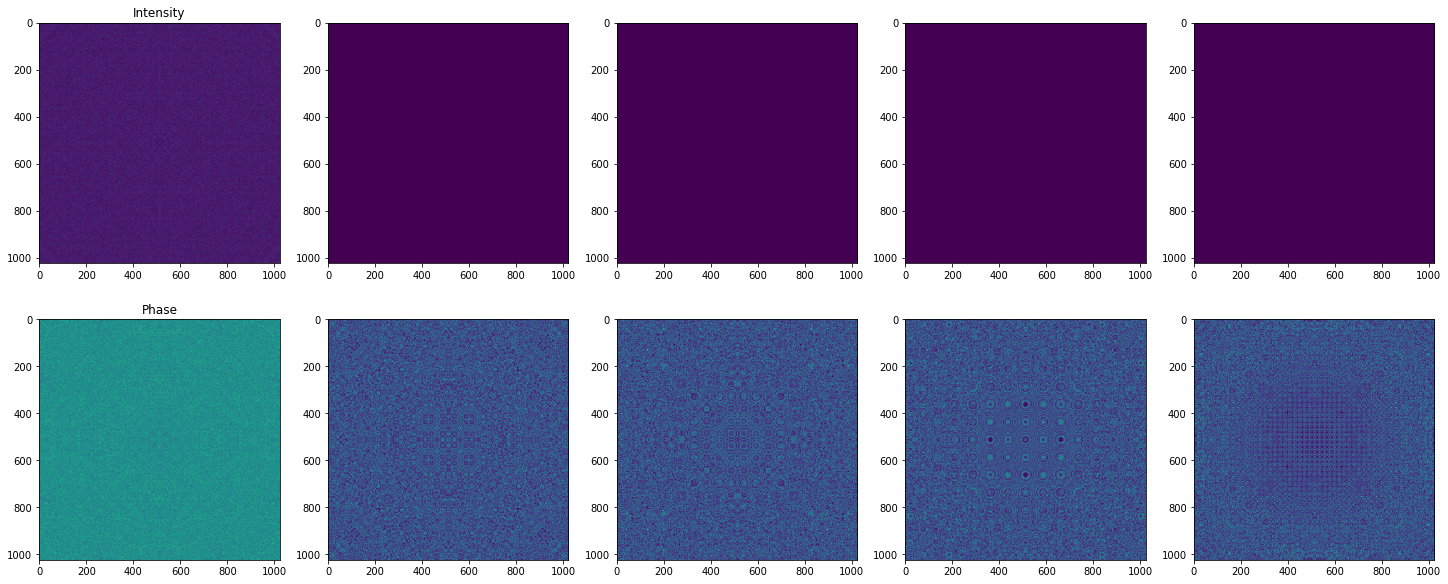

In [29]:
# empty, fields = multi.apply(variables)
empty, fields = multi.apply({'params': params})
show_fields(fields, empty)

Well, that's not right. So let's define a loss and update functions to train with:

In [47]:
def loss(params, gt_empty: jnp.array, gt_sample: jnp.array):
    sim_empty, sim_sample = multi.apply({'params': params})
    l1_empty = jnp.mean(gt_empty - sim_empty.intensity)
    l1_sample = jnp.mean(gt_sample - sim_sample.intensity) * sim_sample.u.shape[0] # give sample measurements equal weight to empty beam
    return (l1_empty + l1_sample) / (sim_sample.u.shape[0] + 1) # normalize loss so it doesn't depend on the number of sample images

@jit
def update(params, step_sizes, gt_empty: jnp.array, gt_sample: jnp.array):
    grads = grad(loss, allow_int=True)(params, gt_empty, gt_sample)
    for key, val in params.items():
        params[key] = val - step_sizes[key] * grads[key]
    return params
    # return [(w - step_size * dw, b - step_size * db)
    #       for (w, b), (dw, db) in zip(params, grads)]

And let's see where we stand before any training:

In [46]:
print(f'Loss: {loss(params, gt_empty_beam, gt_sample_images)}')
print(f'Gradients: {grad(loss)(params, gt_empty_beam, gt_sample_images)}')

Loss: 0.3619576692581177


TypeError: grad requires real- or complex-valued inputs (input dtype that is a sub-dtype of np.inexact), but got int32. If you want to use Boolean- or integer-valued inputs, use vjp or set allow_int to True.

Now let's give training a shot, defining step sizes for each of the parameters separately:

In [35]:
step_sizes = {'beta_param': 0.01, 'delta_param': 0.01, 'input_field_param': 0.01, 'z1s_param': 1e-9}
num_epochs = 8

import time

for epoch in range(num_epochs):
  start_time = time.time()
  params = update(params, step_sizes, gt_empty_beam, gt_sample_images)
  epoch_time = time.time() - start_time

  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))

TypeError: grad requires real- or complex-valued inputs (input dtype that is a sub-dtype of np.inexact), but got int32. If you want to use Boolean- or integer-valued inputs, use vjp or set allow_int to True.